# Introduction to Autoencoders (and unsupervised learning)

Goal of the lab:
* Understand basics of unsupervised learning
* Understand autoencoders

References:

* http://www.deeplearningbook.org/contents/representation.html

* http://curiousily.com/data-science/2017/02/02/what-to-do-when-data-is-missing-part-2.html

* Content partially based on https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/404_autoencoder.ipynb (I highly recommend the whole repository)

# Whiteboard exercises

(Any left out exercises from the previous labs)

* (0.5) Explain importance of the bottleneck in vanilla autoencoders, i.e. why does input has to be strictly lower dimensional than the input. Describe a different way of achieving bottleneck than just reducing dimensionality (hint: lookup denoising autoencoders, contrastive autoencoders or variational autoencoders)

* (0.5) Discuss role of pretraining in training deep models (see for instance http://www.deeplearningbook.org/contents/representation.html)

# Autoencoder

<img src="http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png", width=700>

<p>
<font size=4>

Vanilla autoencoder minimizes a reconstruction error, usually given by the mean squared error between input and reconstructed input.

</font></p>

<font size=4>
$$L(x, dec(enc(x))) = ||x - dec(enc(x))||^2$$
</font>


<p>
<font size=4>
Encoder and decoder are arbitrary neural networks. Usually decoder in vanilla autoencoders follow the same transformations as encoder layers, but in a reversed order. To prevent finding trivial solutions it is necessary to use a smaller dimensionality of the encoer output.
</font>
</p>

# Setup

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
%matplotlib inline
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [4]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# Exercise 1: Vanilla autoencoder

Tasks:

1. Finish implementation of autoencoder
2. Save reconstructions from the final epoch to 11a_1.png

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, D=3):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, D),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(D,12), # Layers in the decoder in autoencoders usually follow a reverse order
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        # Encode and decode
        en = self.encode(x)
        dec = self.decode(en)
        return en, dec

C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0 | train loss: 0.2315


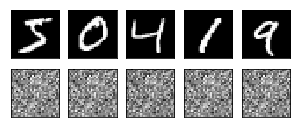

Epoch:  0 | train loss: 0.0579


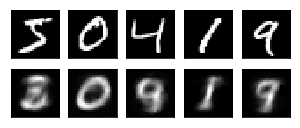

Epoch:  5 | train loss: 0.0370


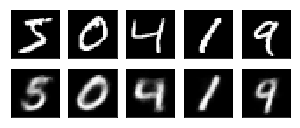

Epoch:  5 | train loss: 0.0356


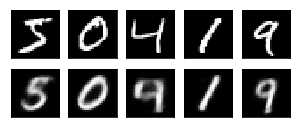

Epoch:  9 | train loss: 0.0354


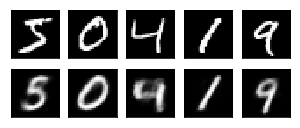

Epoch:  9 | train loss: 0.0382


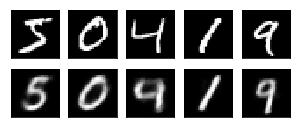

In [9]:
autoencoder = AutoEncoder()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss() # Use MSE loss function

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder.forward(b_x)

        loss = loss_func(decoded, b_y) # See equations for autoencoder
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.savefig('11a_1.png');
            plt.show(); 
            

# Exercise 2: sampling and interpolation using an autoencoder

Task:
1. Fill up missing parts in sampling code and generate 5 examples. Save results to 11a_2a.png
2. Fill up missing parts in interpolation code. Provide an interpolation between for 3 pairs of training examples. Save figures to 11a_2b_%id.png
3. Change architecture of the autoencoder to 128 -> 128 -> 128, with a Tanh nonlinearity in the middle, i.e. enc(x) = Tanh(Wx+b) and dec(z)=Sigmoid(Uz). Train this autoencoder. Compare sampling and interpolation results for this model and describe what you observed in 11a_2c.txt.

## Sampling

Theoretically speaking, we cannot sample from autoencoder. But we can! Let's generate new digits.

The heuristic algorithm for sampling from vanilla autoencoder is:
1. Compute mean and std of the dataset
2. Sample $z$ from a Gaussian distribution using the estimated mean and std
3. Decode the sampled $z$ 

Expected result (of course you might sample different digits) <img src="fig/11/expected_11a_2a.png">

In [10]:
samples = []
for step, (x, y) in enumerate(train_loader):
    if len(samples) > 100:
        break
    sample = x.view(-1, 28*28)    
    enc = autoencoder.encode(Variable(sample))
    samples.append(enc.data.numpy())
sampled_z = np.concatenate(samples, axis=0)
mean_Z, std_Z = np.mean(samples), np.std(samples) # Compute mean and std of the empirical distribution in the latent space

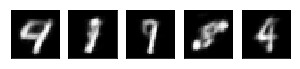

In [14]:
f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 2))
            
for i in range(N_TEST_IMG):
    z_sampled = np.random.normal(mean_Z, std_Z, 3)
    x_decoded = autoencoder.decode(Variable(torch.FloatTensor(z_sampled)))
    a[i].imshow(np.reshape(x_decoded.data.numpy(), (28, 28)), cmap='gray'); 
    a[i].set_xticks(()); 
    a[i].set_yticks(())

plt.savefig("11a_2a.png")

## Interpolation

Interpolation:
1. Encode samples $z_a=enc(x_a)$ and $z_b=enc(x_b)$
2. Let $z(\alpha)=(1 - \alpha) z_a + \alpha z_b$
3. Let $x(\alpha) = dec(z(\alpha))$

Example result <img src="fig/11/expected_11a_2b.png">

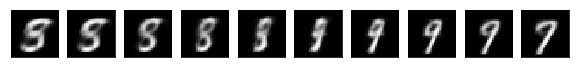

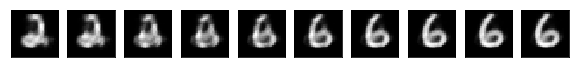

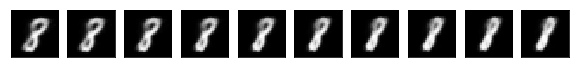

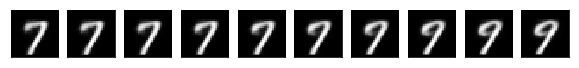

In [31]:
samples = []
for step, (x, y) in enumerate(train_loader):
    if step > 3:
        break
        
    samples.append(1)
    x_a = x[0:1, :]
    x_b = x[1:2, :]
    
    z_a = autoencoder.encode(Variable(x_a.view(-1))).detach().numpy()
    z_b = autoencoder.encode(Variable(x_b.view(-1))).detach().numpy()
    
    f, a = plt.subplots(1, 10, figsize=(10, 3))
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = (1- alpha)*z_a + alpha*z_b
        x_int = autoencoder.decode(Variable(torch.FloatTensor(z_int)))
        a[i].imshow(np.reshape(x_int.data.numpy(), (28, 28)), cmap='gray'); 
        a[i].set_xticks(()); 
        a[i].set_yticks(())   
    
    plt.savefig("11a_2b_{}.png".format(step))
    plt.show()